<a href="https://colab.research.google.com/github/DaeSeokSong/LSTM-PPoA/blob/main/Predict_Price_of_Agricultural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참조문헌
## [A Prediction Model for Agricultural Products Price with LSTM Network](https://www.koreascience.or.kr/article/JAKO201809469053682.page)

**신성호, 이미경, 송사광**

한국과학기술정보연구원 연구데이터플랫폼센터,
한국과학기술정보연구원 연구데이터플랫폼센터/과학기술연합대학원대학교 빅데이터과학과

Sungho Shin(maximus74@kisti.re.kr), Mikyoung Lee(jerryis@kisti.re.kr),
Sa-kwang Song(esmallj@kisti.re.kr)


---
---



# 당년 농산물 가격 예측 LSTM 모델

Input = 1~저번 달까지의 pram 값을 하나로 묶은 array(인스턴스)

output = 당월의 해당 채소 가격

layer = 원래 해당 채소 가격

### Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/DeepLearning/Project/PPoA
!ls -al

Mounted at /content/gdrive
/content/gdrive/MyDrive/DeepLearning/Project/PPoA
total 69
drwx------ 2 root root  4096 Nov 24 06:07  Dataset
-rw------- 1 root root 66479 Nov 27 13:28 'Predict Price of Agricultural.ipynb'


### Import


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import metrics, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Function

In [3]:
def Normalization(targetData) :
    return (targetData - targetData.min()) / (targetData.max() - targetData.min())

### Global variable

In [4]:
TARGET_YEAR = 2020
START_YEAR = 0
END_YEAR = 0
CROPS = ''

### Data read

##### Trained data

In [122]:
START_YEAR = 2006
END_YEAR = 2019
CROPS = 'onion'
dataset = []

# 지난 최대 5년간 최대, 최소치를 기준으로 정규화해야 하는 항목들
df = pd.read_csv('./Dataset/'+CROPS+'/last_production_'+CROPS+'.csv', index_col=0, encoding='cp949')
# 전년 재배면적
last_cultiv_area = df['전년면적']
# 전년 평균 생산량(수확량)
last_production = df['전년생산량']
# 전년 평균 생산단수
last_prod_unit = df['전년단수']
last_prams = [last_cultiv_area,                    # 전년 재배면적
            last_production,                       # 전년 평균 생산량
            last_prod_unit                         # 전년 평균 생산단수
            ]

for next in range(0, (END_YEAR-START_YEAR)+1) :
    cur_year = START_YEAR + next

    f_name = str(cur_year)+'_'+CROPS+'.csv'
    df = pd.read_csv('./Dataset/'+CROPS+'/'+f_name, index_col=0)

    ''' 기상변수 '''
    # 강수량
    precipi_avg = df['평균월강수량(mm)']
    precipi_max = df['최다월강수량(mm)']
    # 기온
    temper_avg = df['평균기온(℃)']
    temper_max = df['평균최고기온(℃)']
    temper_min = df['평균최저기온(℃)']
    # 풍속
    windSpeed_avg = df['평균풍속(m/s)']
    windSpeed_max = df['최대풍속(m/s)']
    # 습도
    humidity_avg = df['평균습도(%rh)']
    humidity_min = df['최저습도(%rh)']
    # 일조량 / 일사량
    sunshine = df['일조합']
    insolation = df['일사합']

    ''' 기타변수 '''
    # 전년 수입량
    last_amount_import = df['전년수입량']
    # 해당 농작물 가격 (index == 12)
    crops_price = df['가격']
    # 경유 가격
    diesel_price = df['경유가격']
    # 물가지수(price index -> pidx), 2015년 기준 얼마나 오르고 내렸는지
    total_pidx = df['총물가지수']
    prod_pidx = df['상품']
    agricul_marine_prod_pidx = df['농축수산물']
    indust_prod_pidx = df['공업제품']
    serv_pidx = df['서비스']
    pub_serv_pidx = df['공공서비스']
    per_serv_pidx = df['개인서비스']
    house_pidx = df['집세']

    # 정규화 해야하는 데이터셋
    prams = [precipi_avg, precipi_max,             # 강수량
            temper_avg, temper_max, temper_min,    # 기온
            windSpeed_avg, windSpeed_max,          # 풍속
            humidity_avg, humidity_min,            # 습도
            sunshine,                              # 일조량
            insolation,                            # 일사량
            crops_price,                           # 해당 농작물 월별 가격
            diesel_price,                          # 월별 경유 가격
            last_amount_import,                    # 전년 수입량
            # 물가지수
            total_pidx, prod_pidx, agricul_marine_prod_pidx, indust_prod_pidx, serv_pidx, pub_serv_pidx, per_serv_pidx, house_pidx,
            ]

    dataset.append(prams)

##### Predicted data

In [129]:
CROPS = 'onion'
pred_dataset = []

# 지난 최대 5년간 최대, 최소치를 기준으로 정규화해야 하는 항목들
df = pd.read_csv('./Dataset/'+CROPS+'/last_production_'+CROPS+'.csv', index_col=0, encoding='cp949')
# 전년 재배면적
last_cultiv_area = df['전년면적']
# 전년 평균 생산량(수확량)
last_production = df['전년생산량']
# 전년 평균 생산단수
last_prod_unit = df['전년단수']
pred_last_prams = [last_cultiv_area,                    # 전년 재배면적
            last_production,                       # 전년 평균 생산량
            last_prod_unit                         # 전년 평균 생산단수
            ]

f_name = str(TARGET_YEAR)+'_'+CROPS+'.csv'
df = pd.read_csv('./Dataset/'+CROPS+'/'+f_name, index_col=0)

''' 기상변수 '''
# 강수량
precipi_avg = df['평균월강수량(mm)']
precipi_max = df['최다월강수량(mm)']
# 기온
temper_avg = df['평균기온(℃)']
temper_max = df['평균최고기온(℃)']
temper_min = df['평균최저기온(℃)']
# 풍속
windSpeed_avg = df['평균풍속(m/s)']
windSpeed_max = df['최대풍속(m/s)']
# 습도
humidity_avg = df['평균습도(%rh)']
humidity_min = df['최저습도(%rh)']
# 일조량 / 일사량
sunshine = df['일조합']
insolation = df['일사합']

''' 기타변수 '''
# 전년 수입량
last_amount_import = df['전년수입량']
# 해당 농작물 가격 (index == 12)
crops_price = df['가격']
# 경유 가격
diesel_price = df['경유가격']
# 물가지수(price index -> pidx), 2015년 기준 얼마나 오르고 내렸는지
total_pidx = df['총물가지수']
prod_pidx = df['상품']
agricul_marine_prod_pidx = df['농축수산물']
indust_prod_pidx = df['공업제품']
serv_pidx = df['서비스']
pub_serv_pidx = df['공공서비스']
per_serv_pidx = df['개인서비스']
house_pidx = df['집세']

# 정규화 해야하는 데이터셋
pred_prams = [precipi_avg, precipi_max,             # 강수량
        temper_avg, temper_max, temper_min,    # 기온
        windSpeed_avg, windSpeed_max,          # 풍속
        humidity_avg, humidity_min,            # 습도
        sunshine,                              # 일조량
        insolation,                            # 일사량
        crops_price,                           # 해당 농작물 월별 가격
        diesel_price,                          # 월별 경유 가격
        last_amount_import,                    # 전년 수입량
        # 물가지수
        total_pidx, prod_pidx, agricul_marine_prod_pidx, indust_prod_pidx, serv_pidx, pub_serv_pidx, per_serv_pidx, house_pidx,
        ]

pred_dataset.append(pred_prams)

### Data preprocessing

##### Trained data

In [124]:
''' 정규화 '''
scaler = MinMaxScaler()
# last_prams
norm_last = []
for idx, pram in enumerate(last_prams) :
    tmp_last = []
    for next in range(0, (END_YEAR-START_YEAR)+1) :
        tmp_df = pram

        cur_year = START_YEAR + next
        year_list = tmp_df.index.values.tolist()
        if cur_year-4 < year_list[-1] : year_list = year_list[year_list.index(cur_year):len(year_list)] # 5년간 데이터가 없을 경우
        else : year_list = year_list[year_list.index(cur_year):year_list.index(cur_year-4)+1]           # 5년간 데이터가 있는 경우

        tmp_df = tmp_df.loc[year_list]
        tmp_last.append(Normalization(tmp_df).to_numpy()[0])
    norm_last.append(tmp_last)

# prams
for idx, data in enumerate(dataset) :
    for i, pram in enumerate(data) :
        pram = Normalization(pram)
        pram = pram.to_numpy()

        dataset[idx][i] = pram

''' 데이터셋 구축 '''
X_dataset = []
y_dataset = []

# X, y 데이터셋 구분
for cur, year in enumerate(dataset) :
    tmp_X1 = [[], [], [], [], []] # 1~5월
    tmp_y1 = [] # 6월
    tmp_X2 = [[], [], [], [] ,[]] # 7~11월
    tmp_y2 = [] # 12월
    for idx, data in enumerate(year) :
        for month in range(0, 12) :
            if idx == 12 : 
                if month == 5 : tmp_y1.append(data[month])
                elif month == 11: tmp_y2.append(data[month])
            else :
                if month < 5 : tmp_X1[month].append(data[month])
                elif month > 5 and month < 11 : tmp_X2[month-6].append(data[month])

    for last_data in norm_last :
        for month in tmp_X1 : month.append(last_data[cur])
        for month in tmp_X2 : month.append(last_data[cur])
    
    X_dataset.append(tmp_X1)
    y_dataset.append(tmp_y1)
    X_dataset.append(tmp_X2)
    y_dataset.append(tmp_y2)

# 데이터 형변환
X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

# reshape X_dataset
X_dataset = X_dataset.reshape(X_dataset.shape[0], X_dataset.shape[1] * X_dataset.shape[2], 1)

##### Predicted data

In [125]:
''' 정규화 '''
# last_prams
norm_last = []
for idx, pram in enumerate(pred_last_prams) :
    tmp_last = []
    tmp_df = pram

    year_list = pram.index.values.tolist()
    if TARGET_YEAR-4 < year_list[-1] : year_list = year_list[year_list.index(TARGET_YEAR):len(year_list)] # 5년간 데이터가 없을 경우
    else : year_list = year_list[year_list.index(TARGET_YEAR):year_list.index(TARGET_YEAR-4)+1]           # 5년간 데이터가 있는 경우

    tmp_df = tmp_df.loc[year_list]
    tmp_last.append(Normalization(tmp_df).to_numpy()[0])
    norm_last.append(tmp_last)

# prams
for idx, data in enumerate(pred_dataset) :
    for i, pram in enumerate(data) :
        pram = Normalization(pram)
        pram = pram.to_numpy()

        pred_dataset[idx][i] = pram

''' 데이터셋 구축 '''
pred_X_dataset = []
pred_y_dataset = []

# X, y 데이터셋 구분
for cur, year in enumerate(pred_dataset) :
    tmp_X1 = [[], [], [], [], []] # 1~5월
    tmp_y1 = [] # 6월
    tmp_X2 = [[], [], [], [] ,[]] # 7~11월
    tmp_y2 = [] # 12월
    for idx, data in enumerate(year) :
        for month in range(0, 12) :
            if idx == 12 : 
                if month == 5 : tmp_y1.append(data[month])
                elif month == 11: tmp_y2.append(data[month])
            else :
                if month < 5 : tmp_X1[month].append(data[month])
                elif month > 5 and month < 11 : tmp_X2[month-6].append(data[month])

    for last_data in norm_last :
        for month in tmp_X1 : month.append(last_data[cur])
        for month in tmp_X2 : month.append(last_data[cur])
    
    pred_X_dataset.append(tmp_X1)
    pred_y_dataset.append(tmp_y1)
    pred_X_dataset.append(tmp_X2)
    pred_y_dataset.append(tmp_y2)

# 데이터 형변환
pred_X_dataset = np.array(pred_X_dataset)
pred_y_dataset = np.array(pred_y_dataset)

# reshape X_dataset
pred_X_dataset = pred_X_dataset.reshape(pred_X_dataset.shape[0], pred_X_dataset.shape[1] * pred_X_dataset.shape[2], 1)

### Data split

In [85]:
# Data division (Train : Test = 9 : 1)
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.1)
print("########## Train + Test (X,) (y,) / Test (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Data division (Train : Validation = 8 : 2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print("########## Train (X,) (y,) / Validation (X,) (y,) ##########")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

########## Train + Test (X,) (y,) / Test (X,) (y,) ##########
(25, 120, 1) (25, 1) (3, 120, 1) (3, 1)
########## Train (X,) (y,) / Validation (X,) (y,) ##########
(20, 120, 1) (20, 1) (5, 120, 1) (5, 1)


### Modeling

In [107]:
model = Sequential()

model.add(Bidirectional(LSTM(64,                    # 해당 층의 노드 개수
                       input_shape=(20, 120, 1),    # input_shape=?
                       return_sequences=True)))     # return_sequences == 각 시퀀스를 출력할지
model.add(Dropout(0.01))                            # 과적합 방지용 Ex. Dropout 20%(==0.2)
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.01))
model.add(Dense(1, activation='relu'))

model.build(input_shape=(20, 120, 1))
model.compile(loss=losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=0.000025), # pram ex. learning_rate=0.0001
              metrics=[metrics.MeanSquaredError()]
              )

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_82 (Bidirecti  (20, 120, 128)           33792     
 onal)                                                           
                                                                 
 dropout_66 (Dropout)        (20, 120, 128)            0         
                                                                 
 bidirectional_83 (Bidirecti  (20, 32)                 18560     
 onal)                                                           
                                                                 
 dropout_67 (Dropout)        (20, 32)                  0         
                                                                 
 dense_43 (Dense)            (20, 1)                   33        
                                                                 
Total params: 52,385
Trainable params: 52,385
Non-tra

### Learning

Epoch 1/408
1/1 [==============================] - 11s 11s/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 2/408
1/1 [==============================] - 0s 157ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 3/408
1/1 [==============================] - 0s 164ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 4/408
1/1 [==============================] - 0s 166ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 5/408
1/1 [==============================] - 0s 167ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 6/408
1/1 [==============================] - 0s 166ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 7/408
1/1 [==================

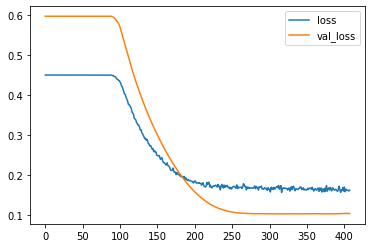

In [108]:
history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size = 24,                    # Train set's 1~2%
                    epochs = 408,                       # Train set's 10%
                    verbose = 1,                        # 0=silent, 1=progress bar, 2=one line per epoch.
                    )

# loss and acc graph (train nd val)
history_df = pd.DataFrame(history.history)
history_df[["loss", "val_loss"]].plot()

# Acc and Loss about real data
learning_lost, learning_err = model.evaluate(X_test, y_test, verbose=2)
print("Learning error % :", learning_err * 100)
print("Learning loss % :", learning_lost * 100)

### Prediction

In [132]:
pred_res = model.predict(pred_X_dataset)

scaler = MinMaxScaler()
scaler.fit(y_dataset)
print("Predicted Price = ", scaler.inverse_transform(pred_res))
print("Real Price = ", scaler.inverse_transform(pred_y_dataset))

Predicted Price =  [[0.47440866]
 [0.5464934 ]]
Real Price =  [[0.18673522]
 [0.30825892]]
